# Setup: (Basic SQL and Data Exploration)

In [227]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import json
import math
from datetime import datetime
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

In [228]:
host = "mysql-1.cda.hhs.se"
username = "7313"
password = "data"
schema = "Survivability"
connection_string = "mysql+pymysql://{}:{}@{}/{}".format(username, password, host, schema)
connection = create_engine(connection_string)

sql_query_a = """
SELECT *
FROM Patient
"""
dfP = pd.read_sql_query(sql_query_a, connection)
dfP.set_index('id', inplace=True)
dfP.sort_index(inplace=True)

In [229]:
# Convert admission_date to datetime
comparison_date = datetime.strptime('2023-12-14', '%Y-%m-%d').date()
current_patients = dfP[(dfP['admission_date'] <= comparison_date) & (dfP['days_before_discharge'].isnull())]

# Set up Json file
patients_data = []
for patient_id in current_patients.index:
    # Create a dictionary for each patient with placeholders
    patient_dict = {
        "patient_id": patient_id,
        "prediction_accuracy_model": None,  # Placeholder
        "white_blood_cell_count": None,     # Placeholder
        "prediction_profit_model": None     # Placeholder
    }
    patients_data.append(patient_dict)

json_filename = 'classification_set.json'

# Save to a JSON file
with open(json_filename, 'w') as file:
    json.dump(patients_data, file, indent=4)  
print(f"Data saved in '{json_filename}'")

Data saved in 'classification_set.json'


# Question 1: (Data-Wrangling & Basic Data Presentation)

In [230]:
sql_query_b = """
SELECT *
FROM PatientExamination
"""
dfPE = pd.read_sql_query(sql_query_b, connection)

# Set 'patient_id' as the index and sort it
dfPE.set_index('patient_id', inplace=True)
dfPE.sort_index(inplace=True)

# Pivot the DataFrame
dfPE = dfPE.pivot(columns='measurement', values='value')

# Filter to only include 'White Blood Cell Count' measurement
dfB = dfPE[['White Blood Cell Count']]

In [231]:
df1 = pd.concat([dfP, dfB], axis=1, join='outer')
df1['White Blood Cell Count'] = pd.to_numeric(df1['White Blood Cell Count'], errors='coerce')

## 1.1

In [232]:
# get the unique values of each of the columns whose Dtype is object
cat_cols = df1.select_dtypes(include=['object']).columns.values.tolist()

for col in cat_cols:
    print("For categorical column {}, there are {} unique values ".format(col, df1[col].nunique()))
# Choose disease_category for visualization

For categorical column admission_date, there are 815 unique values 
For categorical column gender, there are 2 unique values 
For categorical column disease_category, there are 8 unique values 
For categorical column disease_class, there are 4 unique values 
For categorical column language, there are 5 unique values 


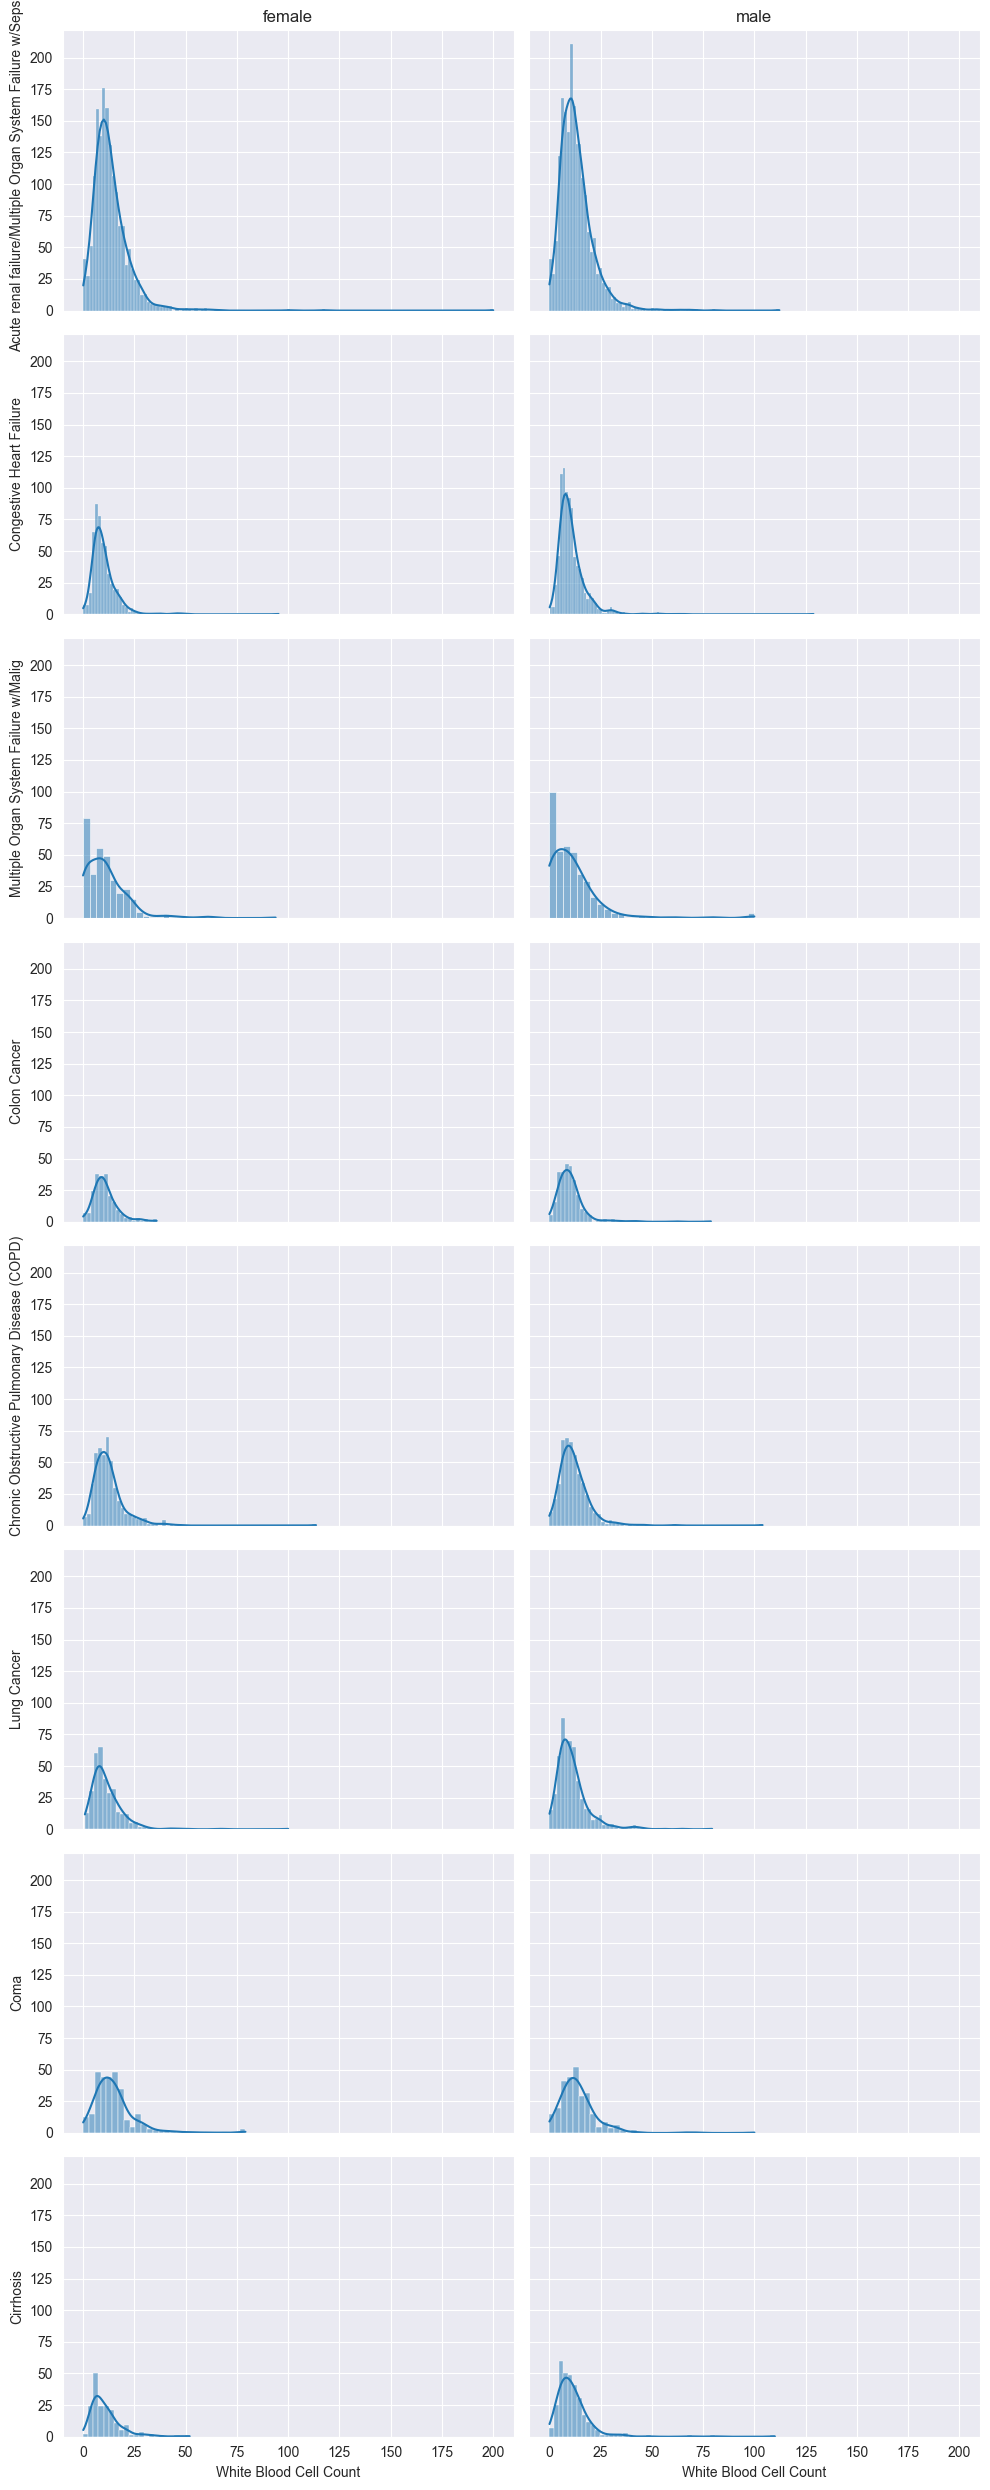

In [233]:
# Get unique categories
categories = df1['disease_category'].unique()
genders = df1['gender'].unique()

# Create a grid of plots - one row for each category and one column for each gender
fig, axes = plt.subplots(nrows=len(categories), ncols=len(genders), figsize=(10, 25), sharex=True, sharey=True)

for i, category in enumerate(categories):
    for j, gender in enumerate(genders):
        subset = df1[(df1['disease_category'] == category) & (df1['gender'] == gender)]
        sns.histplot(subset['White Blood Cell Count'], ax=axes[i, j], kde=True)
        if j == 0:
            axes[i, j].set_ylabel(category)
        if i == 0:
            axes[i, j].set_title(gender)

plt.tight_layout()
plt.savefig("White Blood Cell Count.png")
plt.show()

## 1.2

In [234]:
# set rounded down to the nearest integer, if a value is missing, instead output null under the key: white_blood_cell_count

# Load the existing JSON file
with open('classification_set.json', 'r') as file:
    patients_data = json.load(file)

for patient in patients_data:
    # Find the white blood cell count for the patient
    wbc_count = df1.loc[df1.index == patient['patient_id'], 'White Blood Cell Count'].values
    # Update the patient dictionary
    patient['white_blood_cell_count'] = math.floor(wbc_count[0]) if wbc_count.size > 0 and not pd.isna(wbc_count[0]) else None

# Save the updated data back to the JSON file
with open('classification_1_2.json', 'w') as file:
    json.dump(patients_data, file, indent=4)

print("Updated JSON file saved.")

Updated JSON file saved.


# Question 2: (Accurate predictions)

In [235]:
sql_query_c = """
SELECT *
FROM Study
"""
dfS = pd.read_sql_query(sql_query_c, connection)
dfS.set_index('patient_id', inplace=True)
dfS.sort_index(inplace=True)

In [236]:
df2 = pd.concat([dfP, dfPE, dfS], axis=1, join='outer')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9105 entries, 0004f480-a3ee-4c23-9e94-8a5dc4e68176 to fffe3764-1b0e-434a-a7d2-1f3873865caa
Data columns (total 42 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   admission_date                                9105 non-null   object 
 1   age                                           9105 non-null   int64  
 2   gender                                        9105 non-null   object 
 3   disease_category                              9105 non-null   object 
 4   disease_class                                 9105 non-null   object 
 5   doctors_2_months_survival_prediction          7456 non-null   float64
 6   doctors_6_months_survival_prediction          7472 non-null   float64
 7   do_not_resuscitate                            9075 non-null   float64
 8   language                                      9063 non-null   object 
 9   d

In [237]:
# Drop unnecessary columns 
df2 = df2.drop(['admission_date', 'study_entry_date','death_recorded_after_hospital_discharge','days_in_hospital_before_study','days_of_follow_up','disease_class','days_before_discharge'], axis = 1)

In [238]:
# Drop columns with missing values over 30%
to_drop = []
for col in df2.columns.values.tolist():
    print("For  column {}, there are {} missing values ".format(col, df2[col].isna().sum()))
    if df2[col].isna().sum() > 0.3 * df2.shape[0]:
        to_drop.append(col)
df2 = df2.drop(to_drop, axis=1)

# Drop 'Activities of Daily Living (From Patient)', 'Activities of Daily Living (From Relative)','Blood Urea Nitrogen','Glucose','Serum Albumin','Urine Output','income_bracket'

For  column age, there are 0 missing values 
For  column gender, there are 0 missing values 
For  column disease_category, there are 0 missing values 
For  column doctors_2_months_survival_prediction, there are 1649 missing values 
For  column doctors_6_months_survival_prediction, there are 1633 missing values 
For  column do_not_resuscitate, there are 30 missing values 
For  column language, there are 42 missing values 
For  column Activities of Daily Living (From Patient), there are 5641 missing values 
For  column Activities of Daily Living (From Relative), there are 2867 missing values 
For  column Arterial Blood PH, there are 2284 missing values 
For  column Bilirubin Level, there are 2601 missing values 
For  column Blood Urea Nitrogen, there are 4352 missing values 
For  column Glucose, there are 4500 missing values 
For  column Has Cancer, there are 0 missing values 
For  column Has Dementia, there are 0 missing values 
For  column Has Diabetes, there are 0 missing values 
For 

In [239]:
columns_to_convert = [
    'Arterial Blood PH',
    'Bilirubin Level',
    'Heart Rate',
    'Mean Arterial Blood Pressure',
    'Number of Comorbidities',
    'P/F Ratio',
    'Respiration Rate',
    'SPS Score',
    'Serum Creatinine Level',
    'Serum Sodium Concentration',
    'Simplified Acute Physiology Score III',
    'Temperature',
    'White Blood Cell Count'
]

# Convert object to numeric
for col in columns_to_convert:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

# Convert numeric to object
df2['do_not_resuscitate'] = df2['do_not_resuscitate'].astype('object')

In [240]:
# check unique values again preparing for feature engineering 
cat_cols = df2.select_dtypes(include=['object']).columns.values.tolist()

for col in cat_cols:
    print("For categorical column {}, there are {} unique values ".format(col, df2[col].nunique()))

For categorical column gender, there are 2 unique values 
For categorical column disease_category, there are 8 unique values 
For categorical column do_not_resuscitate, there are 2 unique values 
For categorical column language, there are 5 unique values 
For categorical column Has Cancer, there are 3 unique values 
For categorical column Has Dementia, there are 2 unique values 
For categorical column Has Diabetes, there are 2 unique values 
For categorical column Zodiac Sign, there are 2 unique values 


In [241]:
df_train = df2[~df2.index.isin(current_patients.index)]
df_test = df2[df2.index.isin(current_patients.index)]
y_train = df_train['died_in_hospital']
X_train = df_train.drop(['died_in_hospital'], axis=1)
y_test = df_test['died_in_hospital']
X_test = df_test.drop(['died_in_hospital'], axis=1)

#### Impute any missing values

##### X_train

In [242]:
cat_cols = X_train.select_dtypes(include=['object']).columns.values.tolist()
num_cols = X_train.columns.difference(cat_cols).values.tolist()

# for the numerical columns with missing values, fill the missing values with the mean of the column of the group, groupby disease_category
for column in num_cols:
    mean_per_disease_category = X_train.groupby('disease_category')[column].transform('mean')
    X_train[column] = X_train[column].fillna(mean_per_disease_category)

# for the object columns with missing values, fill the missing values with the mode of the column of the group, groupby disease_category
for column in cat_cols:
    mode_per_disease_category = X_train.groupby('disease_category')[column].transform(
        lambda x: x.mode()[0] if not x.empty and not x.mode().empty else None)
    X_train[column] = X_train[column].fillna(mode_per_disease_category)


##### X_test

In [243]:
# Do the same to X_test

for column in num_cols:
    mean_per_disease_category = X_test.groupby('disease_category')[column].transform('mean')
    X_test[column] = X_test[column].fillna(mean_per_disease_category)

for column in cat_cols:
    mode_per_disease_category = X_test.groupby('disease_category')[column].transform(
        lambda x: x.mode()[0] if not x.empty and not x.mode().empty else None)
    X_test[column] = X_test[column].fillna(mode_per_disease_category)

##### Encoding cat_cols

In [244]:
label_encoder = LabelEncoder()

for col in cat_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    
for col in cat_cols:
    X_test[col] = label_encoder.fit_transform(X_test[col])

# Model

In [245]:
# Split the data into training and test sets
# Set random_state = 42
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# StandardScaler numeric columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

#### Baseline models

In [246]:
# Function to evaluate classifiers, print results, and return performance DataFrame
def evaluate_classifiers(classifier_list, X_train, X_val, y_train, y_val):
    performance = {}
    for name, clf in classifier_list:
        clf.fit(X_train, y_train)
        train_preds = clf.predict(X_train)
        val_preds = clf.predict(X_val)

        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, train_preds)
        val_accuracy = accuracy_score(y_val, val_preds)

        # Store results
        performance[name] = {'Training Accuracy': train_accuracy, 'Validation Accuracy': val_accuracy}

    # Convert the performance dictionary to a DataFrame and print it
    performance_df = pd.DataFrame(performance).T
    print("\nOverall Performance Summary:")
    print(performance_df)
    
    return performance_df

classifier_list = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('SGD Classifier', SGDClassifier(random_state=42)),
    ('Random Forest Classifier', RandomForestClassifier(random_state=42)),
    ('XGBoost Classifier', xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=42))
]

performance_df = evaluate_classifiers(classifier_list, X_train, X_val, y_train, y_val)

# Choose Random Forest Classifier and Logistic Regression for further step


Overall Performance Summary:
                          Training Accuracy  Validation Accuracy
Logistic Regression                0.833745             0.838371
SGD Classifier                     0.818785             0.837754
Random Forest Classifier           1.000000             0.837754
XGBoost Classifier                 0.993523             0.818014


# Feature Selection

#### Pilot selection by sklearn.feature_selection module

L1-based feature selection

In [247]:
# Create and fit a LogisticRegression model with L1 regularization
l1_logistic = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
l1_logistic.fit(X_train, y_train)

print("Coefficients:", l1_logistic.coef_)

# Initialize and fit SelectFromModel with the fitted LogisticRegression model
feature_selector = SelectFromModel(estimator=l1_logistic)
feature_selector.fit(X_train, y_train)

# Get the selected features
selected_features = feature_selector.get_support()

# Transform the original data to include only the selected features
X_selected_l = feature_selector.transform(X_train)
X_val_l = feature_selector.transform(X_val)

print("Selected Features:", selected_features)


Coefficients: [[ 0.          0.         -0.10678004 -0.58397842  0.          0.
  -0.04261865  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.35848139  0.          0.          0.
   0.         -0.80910443  0.        ]]
Selected Features: [False False  True  True False False  True False False False False False
 False False False False False False False False  True False False False
 False  True False]


Tree-based feature selection

In [248]:
clf_rfc = RandomForestClassifier(random_state=42)
clf_rfc.fit(X_train, y_train)

# Feature importances
importances = clf_rfc.feature_importances_

# Create a SelectFromModel object with the random forest estimator
selector = SelectFromModel(clf_rfc, prefit=True)

X_selected_tree = selector.transform(X_train)
X_val_tree = selector.transform(X_val)

print("Original number of features:", X_train.shape[1])
print("Selected number of features:", X_selected_tree.shape[1])
print("Feature Importances:", importances)


Original number of features: 27
Selected number of features: 8
Feature Importances: [0.03219099 0.00571917 0.01919614 0.08858266 0.05996096 0.00143805
 0.00668099 0.0307687  0.03336473 0.01454439 0.00173654 0.00445505
 0.03348649 0.03591606 0.01672005 0.03709314 0.02973812 0.0690061
 0.03266351 0.02964299 0.09006799 0.03325736 0.03738568 0.00020638
 0.02562396 0.1327241  0.09782971]


/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/yaffa/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


#### Evaluate feature selection

In [249]:
classifier_list = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest Classifier', RandomForestClassifier(random_state=42)),
]
# Initial data for comparison
performance = evaluate_classifiers(classifier_list, X_train, X_val, y_train, y_val)

classifier_list = [('Logistic Regression', LogisticRegression(random_state=42))]
performance = evaluate_classifiers(classifier_list, X_selected_l, X_val_l, y_train, y_val)

classifier_list = [('Random Forest Classifier', RandomForestClassifier(random_state=42))]
performance = evaluate_classifiers(classifier_list, X_selected_tree, X_val_tree, y_train, y_val)

# Performance didn't improve, thus not move forward with these function 


Overall Performance Summary:
                          Training Accuracy  Validation Accuracy
Logistic Regression                0.833745             0.838371
Random Forest Classifier           1.000000             0.837754

Overall Performance Summary:
                     Training Accuracy  Validation Accuracy
Logistic Regression           0.830043             0.831585

Overall Performance Summary:
                          Training Accuracy  Validation Accuracy
Random Forest Classifier                1.0             0.834053


#### Feature Engineering

In [250]:
# Set a random seed for reproducibility
mi = mutual_info_classif(X_train, y_train, random_state=42)
mi_df = pd.DataFrame(mi, index=X_train.columns, columns=['Mutual Information'])
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df)

                                              Mutual Information
existing_models_2_months_survival_prediction            0.161781
existing_models_6_months_survival_prediction            0.133459
doctors_2_months_survival_prediction                    0.125503
SPS Score                                               0.113773
Simplified Acute Physiology Score III                   0.113750
doctors_6_months_survival_prediction                    0.101629
disease_category                                        0.075563
Bilirubin Level                                         0.039830
P/F Ratio                                               0.037617
years_of_education                                      0.027224
Arterial Blood PH                                       0.026370
Mean Arterial Blood Pressure                            0.020265
Respiration Rate                                        0.016746
Heart Rate                                              0.013784
Serum Creatinine Level   

In [251]:
# Drop zero_mi_features
zero_mi_features = mi_df[mi_df['Mutual Information'] == 0].index
print("to drop" , zero_mi_features)
X_train = X_train.drop(columns=zero_mi_features)
X_test = X_test.drop(columns=zero_mi_features)
X_val = X_val.drop(columns=zero_mi_features)

to drop Index(['Has Dementia', 'Zodiac Sign', 'language'], dtype='object')


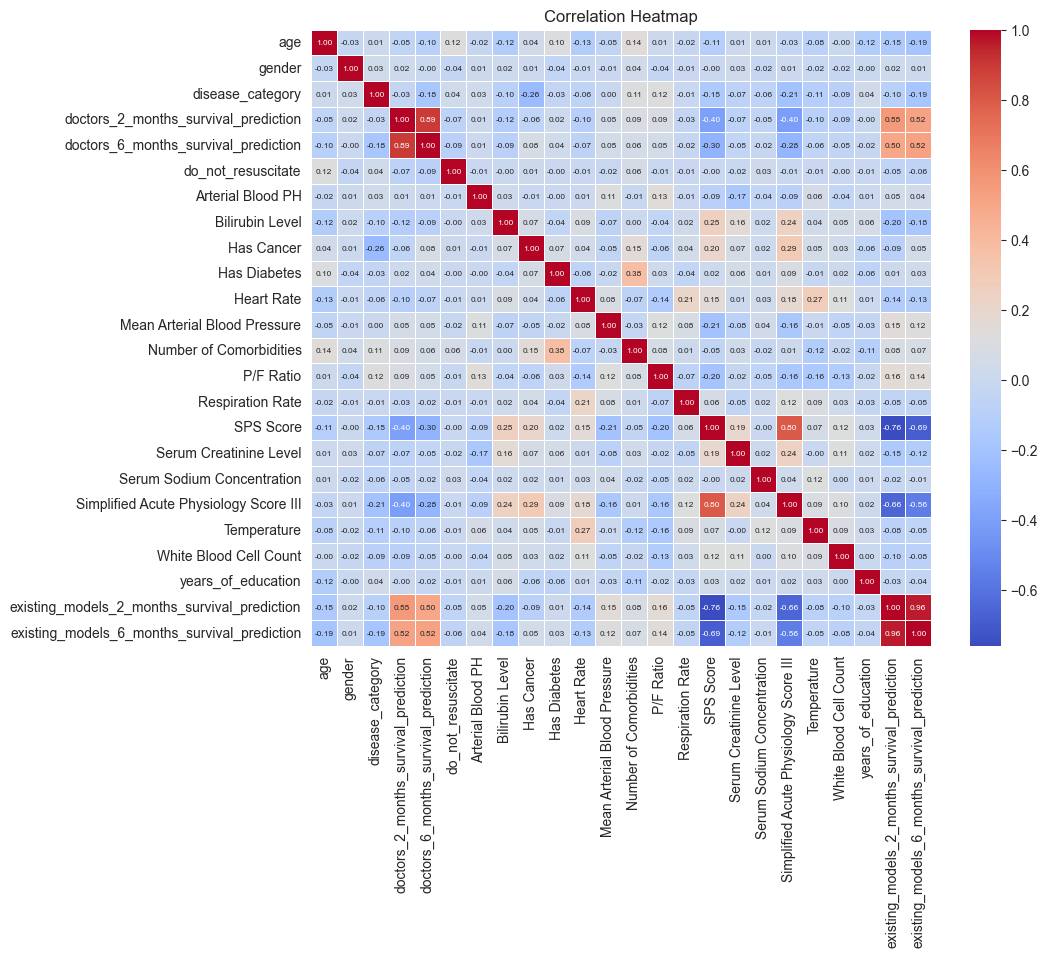

In [252]:
# check the correlation between columns
corr = X_train.corr()
# plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,annot_kws={"size": 6})
plt.title("Correlation Heatmap")
plt.show()
# Not move forward to PCA

#### Select Model

In [253]:
classifier_list = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest Classifier', RandomForestClassifier(random_state=42))
]
performance_df = evaluate_classifiers(classifier_list, X_train, X_val, y_train, y_val)


Overall Performance Summary:
                          Training Accuracy  Validation Accuracy
Logistic Regression                0.833899             0.838988
Random Forest Classifier           1.000000             0.837754


# FINAL MODEL Random Forest

#### Improve the model by cross_validation and tuning the hyperparameters

In [254]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the grid search model with cross-validation
grid_search = GridSearchCV(estimator=clf_rfc, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation in CV Scores: {cv_scores.std()}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validation Accuracy Scores: [0.82189668 0.82266769 0.82960678 0.83423285 0.81635802]
Mean CV Accuracy: 0.8249524067886955
Standard Deviation in CV Scores: 0.006264351844989998


## 2.2 Present the performance of your model in a confusion matrix

In [255]:
# Make predictions on the test set
y_pred = best_rf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)

[[1114   84]
 [ 169  254]]


# 2.3 Output the classification of the patient 

#### Prediction 

In [256]:
prediction = best_rf.predict(X_test)
predictions_with_index = pd.DataFrame(prediction, index=X_test.index,columns=['Prediction'])

In [257]:
mi_pre = mutual_info_classif(X_test, prediction,random_state=42)
mi_dfa = pd.DataFrame(mi_pre, index=X_test.columns, columns=['Mutual Information'])
mi_dfa = mi_dfa.sort_values(by='Mutual Information', ascending=False)
mi_dfa

,Mutual Information
existing_models_2_months_survival_prediction,0.227241
existing_models_6_months_survival_prediction,0.181854
doctors_2_months_survival_prediction,0.164886
SPS Score,0.147921
doctors_6_months_survival_prediction,0.123138
Simplified Acute Physiology Score III,0.118796
disease_category,0.083085
Bilirubin Level,0.031452
P/F Ratio,0.026140
Has Cancer,0.025219


In [258]:
# Load the existing JSON file
with open('classification_1_2.json', 'r') as file:
    patients_data = json.load(file)

for patient in patients_data:
    patient_id = patient['patient_id']
    if patient_id in predictions_with_index.index:
        # Update the patient dictionary with the prediction
        patient['prediction_accuracy_model'] = int(predictions_with_index.loc[patient_id, 'Prediction'])
    else:
        patient['prediction_accuracy_model'] = None  

# Save the updated data back to the JSON file
with open('classification_2_3.json', 'w') as file:
    json.dump(patients_data, file, indent=4)

print("Updated JSON file saved.")

Updated JSON file saved.


# Question 3: (Applied learnings and building a case)

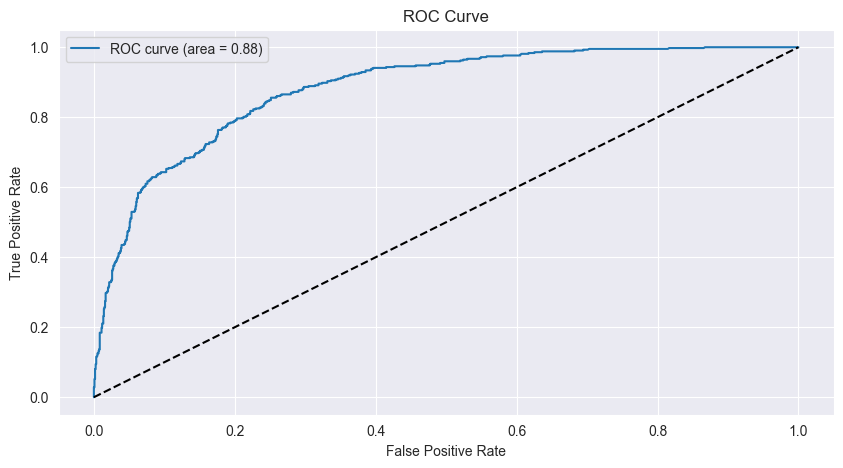

In [259]:
#  Probabilities of the positive class (death)
probabilities = best_rf.predict_proba(X_val)[:, 1]  #

# Calculate precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_val, probabilities)

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_val, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig("ROC curve.png")
plt.show()

In [260]:
# Calculate net savings for each threshold
net_savings = []
for thresh in thresholds_pr:
    # Convert probabilities to binary decisions
    decisions = (probabilities >= thresh).astype(int)

    # Calculate TP, FP
    TP = ((decisions == 1) & (y_val == 1)).sum()
    FP = ((decisions == 1) & (y_val == 0)).sum()

    # Calculate expected savings and costs
    expected_savings = TP * 350000  # €350,000 per TP
    cost_FP = FP * 150000  # €150,000 per FP

    # Net savings
    net = expected_savings - cost_FP
    net_savings.append(net)

# Find the threshold that maximizes net savings
optimal_idx = np.argmax(net_savings)
optimal_threshold = thresholds_pr[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")


Optimal Threshold: 0.29925


# 3.2

In [261]:
# For each patient, if the model's predicted probability of expiry is above optimal_threshold, offload the policy to EvilCorp. If below, keep it.

y_prob = best_rf.predict_proba(X_test)[:, 1] 
offload_decisions = (y_prob >= optimal_threshold).astype(int)
offloading_df = pd.DataFrame({
    'patient_id': X_test.index,  # Replace with the actual patient IDs
    'predicted_probability_of_expiry': y_prob,
    'offload_decision': offload_decisions
})
offloading_df.set_index('patient_id', inplace=True)
offloading_df.sort_index(inplace=True)

# Display the DataFrame with offloading decisions
print(offloading_df)

                                      predicted_probability_of_expiry  \
patient_id                                                              
003eb0e2-821f-4ecb-9238-03bb4a948182                         0.005833   
0136ad0f-465d-4cdd-91bc-c2d8c5c1f35e                         0.449000   
01923875-ad74-44be-bd81-755e287f45b7                         0.003333   
02a1703b-5ed3-4c84-8842-4d2369fd196b                         0.912500   
0306e63b-6ac1-40ff-b6d7-e4370812d10f                         0.000000   
...                                                               ...   
ff853f81-95c2-4f7a-97f3-b414738af8ba                         0.576452   
ff879ec4-a951-40eb-95af-2d4de189d49c                         0.005000   
ffc20438-2035-4cdd-86f5-50a7f9da86bd                         0.328667   
ffc906dc-d085-4b9e-86b8-62ae9c230925                         0.344833   
ffd96f74-3a70-484d-a169-7558ee2b5445                         0.446500   

                                      offload_deci

In [262]:
# Load the existing JSON file
with open('classification_2_3.json', 'r') as file:
    patients_data = json.load(file)

for patient in patients_data:
    patient_id = patient['patient_id']
    if patient_id in offloading_df.index:
        # Update the patient dictionary with the prediction
        patient['prediction_profit_model'] = int(offloading_df.loc[patient_id, 'offload_decision'])
    else:
        patient['prediction_profit_model'] = None  

# Save the updated data back to the JSON file
with open('final.json', 'w') as file:
    json.dump(patients_data, file, indent=4)

print("Updated JSON file saved.")

Updated JSON file saved.


# 3.3

In [263]:
predicted_probability_of_expiry = probabilities  # array of predicted probabilities
actual_outcomes = y_val  

# Determine offloading decision for each patient
offload_decisions_val = predicted_probability_of_expiry >= optimal_threshold

# Calculate costs (in thousands for now, will convert to millions later)
cost_per_patient_do_nothing = actual_outcomes * 500
cost_per_patient_sell_all = np.ones_like(actual_outcomes) * 150
cost_per_patient_model = offload_decisions_val * 150 + (~offload_decisions_val & actual_outcomes) * 500

# Total costs
total_cost_do_nothing = np.sum(cost_per_patient_do_nothing)
total_cost_sell_all = np.sum(cost_per_patient_sell_all)
total_cost_model = np.sum(cost_per_patient_model)

# Estimated savings (in thousands)
savings_model = min(total_cost_do_nothing, total_cost_sell_all) - total_cost_model

# Convert costs and savings to millions of Euros, round them, and use negative numbers for costs
table_data = {
    "Strategy": [
        "Cost of Doing Nothing",
        "Cost of Selling All Claims",
        "Cost When Using Profit Maximization Model",
        "Estimated Savings to KindCorp"
    ],
    "Effect (m EUR)": [
        round(-total_cost_do_nothing / 1000),
        round(-total_cost_sell_all / 1000),
        round(-total_cost_model / 1000),
        round(savings_model / 1000)
    ]
}

table = pd.DataFrame(table_data)
table.set_index('Strategy', inplace=True)
print(table)

                                           Effect (m EUR)
Strategy                                                 
Cost of Doing Nothing                                -212
Cost of Selling All Claims                           -243
Cost When Using Profit Maximization Model            -130
Estimated Savings to KindCorp                          82


#### 3.4

In [264]:
# Calculate the current FP and FN
current_fp = np.sum((offload_decisions_val == 1) & (actual_outcomes == 0))
current_fn = np.sum((offload_decisions_val == 0) & (actual_outcomes == 1))

# Total number of val_patients
total_patients = len(predicted_probability_of_expiry)

# Total number of actual deaths in val
actual_deaths = np.sum(actual_outcomes)

# Function to calculate financial costs
def calculate_costs(fp, fn, total_patients, actual_deaths):
    cost_do_nothing = actual_deaths * 500  # cost if KindCorp does nothing
    cost_sell_all = total_patients * 150  # cost if KindCorp sells all claims
    cost_model = fp * 150 + fn * 500  # cost using the model (offloading FP and FN)
    return cost_do_nothing, cost_sell_all, cost_model

# Define scenarios with different FP and FN rates
fp_rate_adjustments = [0.5, 1, 1.5]  # 50%, 100% (current rate), 150% of current FP rate
fn_rate_adjustments = [0.5, 1, 1.5]  # 50%, 100% (current rate), 150% of current FN rate

# Calculate impacts for each scenario
results = {}
for fp_adj in fp_rate_adjustments:
    for fn_adj in fn_rate_adjustments:
        adjusted_fp = int(current_fp * fp_adj)
        adjusted_fn = int(current_fn * fn_adj)
        cost_do_nothing, cost_sell_all, cost_model = calculate_costs(adjusted_fp, adjusted_fn, total_patients, actual_deaths)
        net_savings = min(cost_do_nothing, cost_sell_all) - cost_model
        scenario_name = f"FP Rate x{fp_adj}, FN Rate x{fn_adj}"
        results[scenario_name] = {
            "Cost of Doing Nothing (m EUR)": round(-cost_do_nothing / 1000),
            "Cost of Selling All Claims (m EUR)": round(-cost_sell_all / 1000),
            "Cost When Using Profit Maximization Model (m EUR)": round(-cost_model / 1000, 2),
            "Estimated Savings to KindCorp (m EUR)": round(net_savings / 1000)
        }

results_df = pd.DataFrame(results).T
print(results_df)


                            Cost of Doing Nothing (m EUR)  \
FP Rate x0.5, FN Rate x0.5                         -212.0   
FP Rate x0.5, FN Rate x1                           -212.0   
FP Rate x0.5, FN Rate x1.5                         -212.0   
FP Rate x1, FN Rate x0.5                           -212.0   
FP Rate x1, FN Rate x1                             -212.0   
FP Rate x1, FN Rate x1.5                           -212.0   
FP Rate x1.5, FN Rate x0.5                         -212.0   
FP Rate x1.5, FN Rate x1                           -212.0   
FP Rate x1.5, FN Rate x1.5                         -212.0   

                            Cost of Selling All Claims (m EUR)  \
FP Rate x0.5, FN Rate x0.5                              -243.0   
FP Rate x0.5, FN Rate x1                                -243.0   
FP Rate x0.5, FN Rate x1.5                              -243.0   
FP Rate x1, FN Rate x0.5                                -243.0   
FP Rate x1, FN Rate x1                                  -24